In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
#Data via Direct Download Method for Your Convenience
import os
import gdown
import numpy as np

# Create the data directory if it doesn't exist
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
    
    

# Direct download for each dataset



#AVISO Test Data
test_AVISO_url = "https://drive.google.com/uc?export=download&id=1TaZVOnTPz6FEJtltQqqyct0cUKC3PVoU"
test_AVISO_data = "testAVISO-SSH_2011.npy"

# Download the file if it doesn't exist
if not os.path.exists(test_AVISO_data):
    gdown.download(test_AVISO_url, test_AVISO_data, quiet=True)

# Load the file with allow_pickle=True
try:
    SSH_test = np.expand_dims(np.load(test_AVISO_data, allow_pickle=True), 3)[:, 25:168+25, 280-168:, :]
    print("File loaded successfully.")
except Exception as e:
    print(f"Error loading file: {e}")

    
    
    #Segmentation Test Data
test_seg_url = "https://drive.google.com/uc?export=download&id=1kOVh3YKszhTKtko3vOwEOpYncBNDIHU7"
test_seg_data = "testSegmentation_2011.npy"

# Download the file if it doesn't exist
if not os.path.exists(test_seg_data):
    gdown.download(test_seg_url, test_seg_data, quiet=True)


# Load the file with allow_pickle=True
try:
    Seg_test = np.expand_dims(np.load(test_seg_data, allow_pickle=True), 3)[:, 25:168+25, 280-168:, :]
    print("File loaded successfully.")
except Exception as e:
    print(f"Error loading file: {e}")

    
    
    
    #AVISO Train Data
train_AVISO_url = "https://drive.google.com/uc?export=download&id=1oqkPYASNBDeazM7J69ETc09YLMVjtaOK"
train_AVISO_data = "trainAVISO-SSH_2000-2010.npy"

# Download the file if it doesn't exist
if not os.path.exists(train_AVISO_data):
    gdown.download(train_AVISO_url, train_AVISO_data, quiet=True)


# Load the file with allow_pickle=True
try:
    SSH_train = np.expand_dims(np.load(train_AVISO_data, allow_pickle=True), 3)[:, 25:168+25, 280-168:, :]
    print("File loaded successfully.")
except Exception as e:
    print(f"Error loading file: {e}")
   





    #Segmentation Train Data
train_seg_url = "https://drive.google.com/uc?export=download&id=1MyMLlT_PVs_IlTUFonDqlIwr4Jq3oBz8"
train_seg_data = "trainSegmentation_2000-2010.npy"

# Download the file if it doesn't exist
if not os.path.exists(train_seg_data):
    gdown.download(train_seg_url, train_seg_data, quiet=True)


# Load the file with allow_pickle=True
try:
    Seg_train = np.expand_dims(np.load(train_seg_data, allow_pickle=True), 3)[:, 25:168+25, 280-168:, :]
    print("File loaded successfully.")
except Exception as e:
    print(f"Error loading file: {e}")    

    
######
SSH_train.shape
SSH_test.shape
######
Seg_train.shape
Seg_test.shape

File loaded successfully.
File loaded successfully.
File loaded successfully.
File loaded successfully.


(365, 168, 168, 1)

(365, 168, 168, 1)

(4018, 168, 168, 1)

(365, 168, 168, 1)

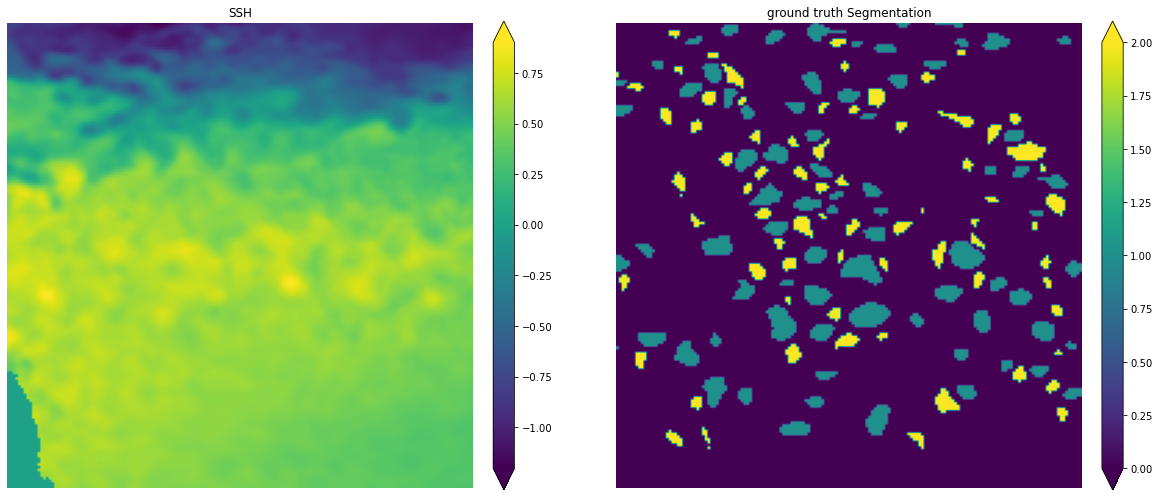

In [7]:
randindex=np.random.randint(0,len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
from keras import utils
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-06-10 14:29:01.388271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
Seg_train_categor = utils.to_categorical(np.reshape(Seg_train[:,:,:,0],(4018,168*168)),3)
Seg_train_categor.shape

(4018, 28224, 3)

In [6]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [7]:
width = 168
height = 168
nbClass = 3
nf = 16
#We changed the nf variable to 8 features to reduced overfitting, performance improved %0.5
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#######################################center

convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

2024-06-10 14:29:18.575160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 168, 168, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 168, 168, 16)         144       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 168, 168, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 168, 168, 16)         0         ['batch_normalization[0][0

In [8]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{0: 100434896, 1: 8225760, 2: 4743376}

In [9]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.02908370281349848, 0.35510623545649606, 0.6158100617300055]

In [10]:

smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.36*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.02*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

In [11]:
eddynet.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss,
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

In [12]:
modelcheck = ModelCheckpoint('./weights/eddynetfirst.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=50,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )

Epoch 1/50


2024-06-10 14:29:43.373164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-10 14:29:44.498053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-10 14:29:45.417545: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe3efbdd450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 14:29:45.417617: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-10 14:29:45.431064: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-10 14:29:45.684486: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

19/19 [==============================] - ETA: 0s - loss: 0.8882 - categorical_accuracy: 0.3682 - mean_dice_coef: 0.2534 - weighted_mean_dice_coef: 0.1123
Epoch 1: val_loss improved from inf to 0.90289, saving model to ./weights/eddynetfirst.h5
19/19 [==============================] - 14s 136ms/step - loss: 0.8882 - categorical_accuracy: 0.3682 - mean_dice_coef: 0.2534 - weighted_mean_dice_coef: 0.1123 - val_loss: 0.9029 - val_categorical_accuracy: 0.7133 - val_mean_dice_coef: 0.2537 - val_weighted_mean_dice_coef: 0.0978 - lr: 0.0010
Epoch 2/50
18/19 [===========================>..] - ETA: 0s - loss: 0.8743 - categorical_accuracy: 0.3858 - mean_dice_coef: 0.2676 - weighted_mean_dice_coef: 0.1257
Epoch 2: val_loss improved from 0.90289 to 0.90242, saving model to ./weights/eddynetfirst.h5
19/19 [==============================] - 1s 64ms/step - loss: 0.8743 - categorical_accuracy: 0.3864 - mean_dice_coef: 0.2683 - weighted_mean_dice_coef: 0.1260 - val_loss: 0.9024 - val_categorical_accura

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

FileNotFoundError: [Errno 2] No such file or directory: 'results/loss_orig.png'

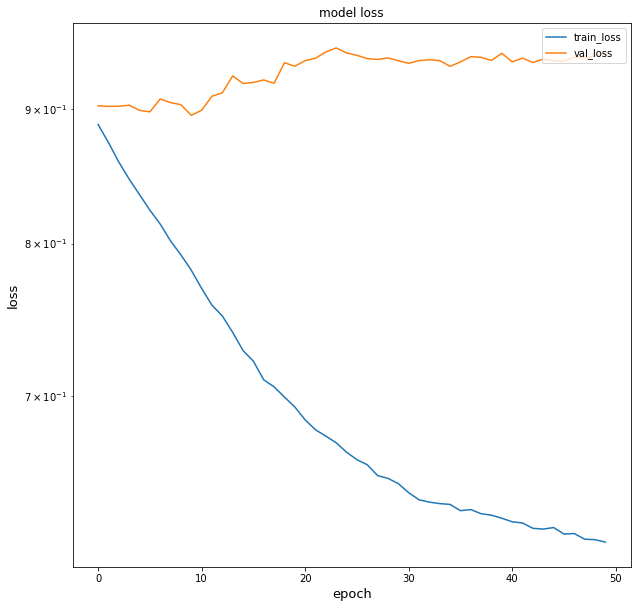

In [13]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss', fontsize = '13')
plt.xlabel('epoch', fontsize = '13')
plt.legend(['train_loss', 'val_loss'], loc='upper right');
plt.savefig("results/loss_orig", facecolor='white')

In [ ]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');
plt.savefig("results/segmentation_orig", facecolor='white')